# Medium_range National Water Model Forecast
### Workflow for creating a 10-day (no ensemble members) or 8.5-day (with ensemble members) streamflow forecast given a date, time, and NHDplus COMID (stream segment identifier)

In [1]:
import gcsfs
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import json
import os
import pandas as pd
from scipy.interpolate import interp1d

%matplotlib inline

## Set up the Google Cloud File System

In [2]:
fs = gcsfs.GCSFileSystem(project='national-water-model')

# Set the parameters

In [3]:
date = '20190802' # a date
start_time = '00' # start at 00:00 because its easy at the moment
comid = 4512772 # some small segment on the Potomac near DC
# comid = 229757 # the South Platte River in Denver
# comid = 7471678 # somewhere on the Mississippi River

## Open all netcdf files of interest, concat them into an xarray multifile dataset -- **_1 for each member_**

- This step takes longer than expected due to reading from GCS over the internet

#### Prior to June 2019, there was only one medium range forecast, not 7 members. The if/else accounts for that but can most likely be removed in the future

In [4]:
datepath = f'national-water-model/nwm.{date}'
if 'medium_range_mem' in str(fs.ls(datepath)): 
    xr_datasets = []
    multi_mem = True
    len_forecast = '8.5-day'
    for i in range(1,8): # ensemble members
        mem = str(i)
        open_ncdfs = []
        for i in range(3, 205, 3): # for times 3-240 or 3-204 in steps of 3
            hr = str(i).zfill(3)
            filepath = f'national-water-model/nwm.{date}/medium_range_mem{mem}/nwm.t{start_time}z.medium_range.channel_rt_{mem}.f{hr}.conus.nc'
            file = fs.open(filepath, 'rb')
            open_ncdfs.append(file)
        mfdset = xr.open_mfdataset(open_ncdfs)
        xr_datasets.append(mfdset)

else:
    multi_mem = False
    len_forecast = '10-day'
    open_ncdfs = []
    for i in range(3, 241, 3): # for times 3-240 or 3-204 in steps of 3
        hr = str(i).zfill(3)
        filepath = f'national-water-model/nwm.{date}/medium_range_mem{mem}/nwm.t{start_time}z.medium_range.channel_rt.f{hr}.conus.nc'
        file = fs.open(filepath, 'rb')
        open_ncdfs.append(file)
    mfdset = xr.open_mfdataset(open_ncdfs)
    
print(f'Multi-member: {multi_mem}')

Multi-member: True


## Get the model analysis_assim time and streamflow (AKA time zero)

In [5]:
filepath = f'national-water-model/nwm.{date}/analysis_assim/nwm.t{start_time}z.analysis_assim.channel_rt.tm00.conus.nc'
file = fs.open(filepath, 'rb')
assim = xr.open_dataset(file)
ds = assim.sel(feature_id=comid)
assim_time = ds['time'].values.astype(str)[0]
df = assim['streamflow'].to_dataframe()
assim_flow = df.loc[comid].values[0]

## Pull the data from each multifile xarray dataset, make a list of dictionaries

In [6]:
outjson = []
for ds in xr_datasets:
    output_da = ds.sel(feature_id=comid)['streamflow']
    times = output_da['time'].values.astype(str)
    arr = output_da.values
    d = {}
    d[ds.attrs['ensemble_member_number']] = {**{assim_time: assim_flow}, **dict(zip(times, arr))}
    outjson.append(d)

## Dump them into a pandas dataframe

In [7]:
df = pd.concat([pd.read_json(json.dumps(x), orient='index') for x in outjson]).T
df['mean'] = df.mean(axis=1)
df.head()

,1,2,3,4,5,6,7,mean
2019-08-02 00:00:00,112.699997,112.699997,112.699997,112.699997,112.699997,112.699997,112.699997,112.699997
2019-08-02 03:00:00,129.759997,129.759997,129.759997,129.759997,129.759997,129.759997,129.759997,129.759997
2019-08-02 06:00:00,138.559997,138.529997,138.529997,138.529997,138.529997,138.529997,138.529997,138.534283
2019-08-02 09:00:00,140.929997,140.879997,140.879997,140.879997,140.879997,140.889997,140.879997,140.888568
2019-08-02 12:00:00,141.029997,140.989997,140.989997,140.989997,140.989997,141.029997,140.989997,141.001425


## Stats

In [8]:
stats = df.T.describe()
stats

,2019-08-02 00:00:00,2019-08-02 03:00:00,2019-08-02 06:00:00,2019-08-02 09:00:00,2019-08-02 12:00:00,2019-08-02 15:00:00,2019-08-02 18:00:00,2019-08-02 21:00:00,2019-08-03 00:00:00,2019-08-03 03:00:00,...,2019-08-09 09:00:00,2019-08-09 12:00:00,2019-08-09 15:00:00,2019-08-09 18:00:00,2019-08-09 21:00:00,2019-08-10 00:00:00,2019-08-10 03:00:00,2019-08-10 06:00:00,2019-08-10 09:00:00,2019-08-10 12:00:00
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,112.699997,129.759997,138.534283,140.888568,141.001425,140.505711,139.858568,139.251425,138.801425,138.624283,...,132.912854,132.365711,131.828568,131.312854,130.825711,130.364283,129.939997,129.567140,129.284283,129.177140
std,0.000000,0.000000,0.010498,0.017261,0.018070,0.048655,0.123569,0.198741,0.385354,0.726535,...,6.738467,6.608805,6.470468,6.327070,6.169653,6.009991,5.842458,5.681151,5.531677,5.447124
min,112.699997,129.759997,138.529997,140.879997,140.989997,140.479997,139.789997,139.049997,138.299997,137.629997,...,124.329997,123.879997,123.479997,123.119997,122.809997,122.539997,122.329997,122.179997,121.979997,121.669997
25%,112.699997,129.759997,138.529997,140.879997,140.989997,140.479997,139.789997,139.102497,138.514997,138.239997,...,129.034997,128.672497,128.324997,127.987497,127.689997,127.404997,127.157497,126.937497,126.784997,126.724997
50%,112.699997,129.759997,138.529997,140.879997,140.989997,140.479997,139.799997,139.230711,138.845711,138.677140,...,132.741426,132.167854,131.589283,131.036426,130.517854,130.042140,129.624997,129.278569,129.032140,128.943569
75%,112.699997,129.759997,138.531068,140.888925,141.008568,140.509283,139.866425,139.324997,139.017497,138.937497,...,135.714997,135.154997,134.612497,134.107497,133.624997,133.159997,132.709997,132.329997,132.199997,132.717497
max,112.699997,129.759997,138.559997,140.929997,141.029997,140.619997,140.149997,139.649997,139.369997,139.719997,...,145.429997,144.519997,143.599997,142.669997,141.739997,140.829997,139.949997,139.129997,138.349997,137.629997


## Plot the stream flow and the statistics

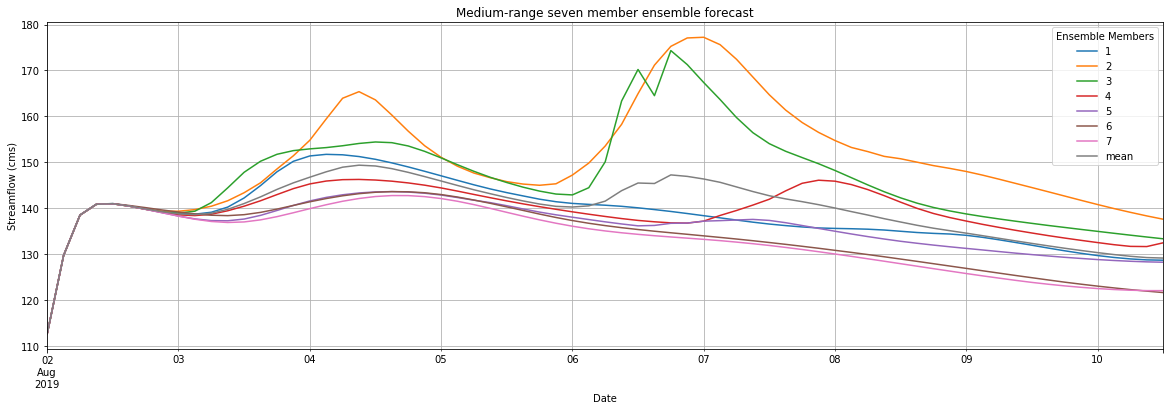

In [9]:
ax = df.plot(figsize=(20,6), title='Medium-range seven member ensemble forecast')
ax.legend(title='Ensemble Members')
ax.grid(True, which="both")
ax.set(xlabel='Date', ylabel='Streamflow (cms)');

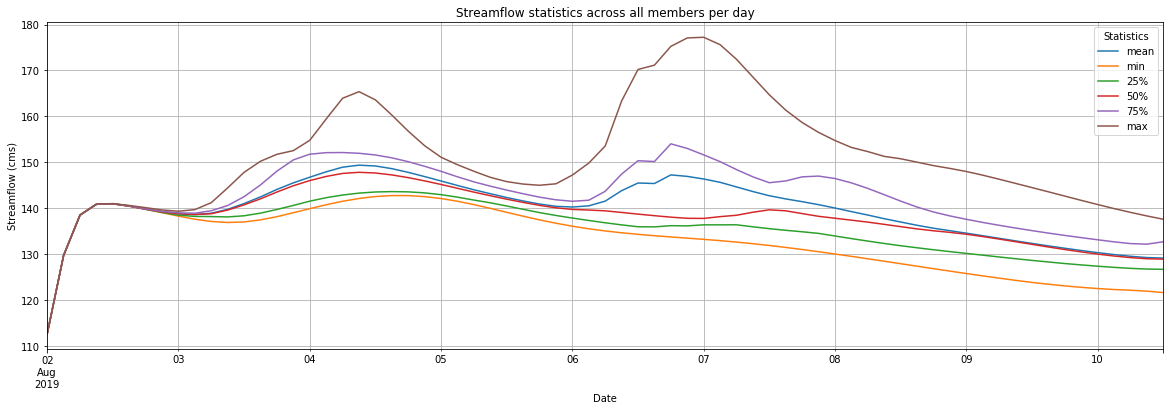

In [10]:
ax = stats.T.drop(columns=['count', 'std']).plot(figsize=(20,6), title ='Streamflow statistics across all members per day')
ax.legend(title='Statistics')
ax.grid(True, which="both")
ax.set(xlabel='Date', ylabel='Streamflow (cms)');

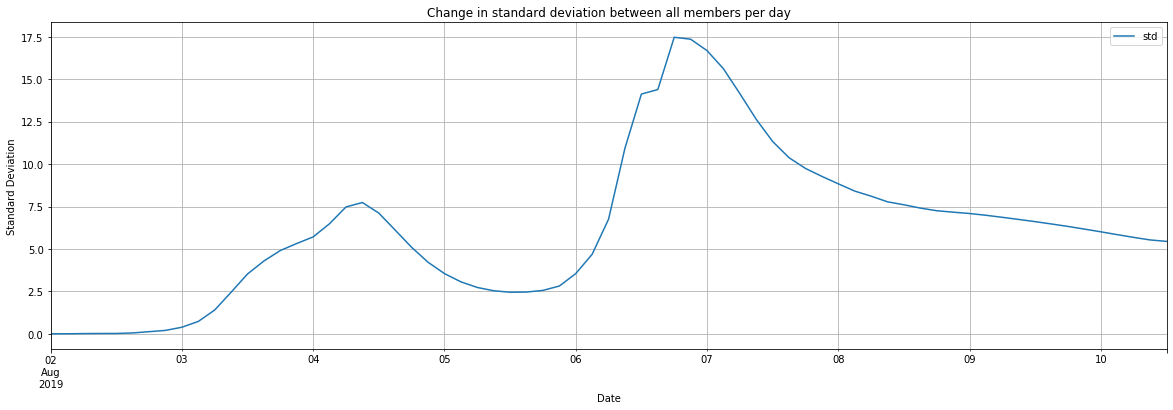

In [11]:
ax = stats.T.drop(columns=[x for x in list(stats.T.columns) if 'std' not in x]).plot(figsize=(20,6), title ='Change in standard deviation between all members per day')
ax.grid(True, which="both")
ax.set(xlabel='Date', ylabel='Standard Deviation');

# Convert Flow to Stage

In [12]:
ds = xr.open_dataset(r'data/hydroprop-fulltable2D.nc')
dis_ds = ds.Discharge.sel(CatchId=comid)
dis_df = dis_ds.to_dataframe().reset_index().drop(columns=['CatchId']).dropna()

In [13]:
dis_df.head()

,Stage,Discharge
0,0.0000,0.000000
1,0.3048,30.085741
2,0.6096,96.720480
3,0.9144,180.899337
4,1.2192,323.340296


## Make an interpolation function to convert from streamflow to stage based on the rating curve provided by the NWM

In [14]:
f = interp1d(dis_df.Discharge, dis_df.Stage, kind='cubic')
stage_df = df.apply(f)
stage_stats = stage_df.T.describe()

## Plot the forecasted stage depth

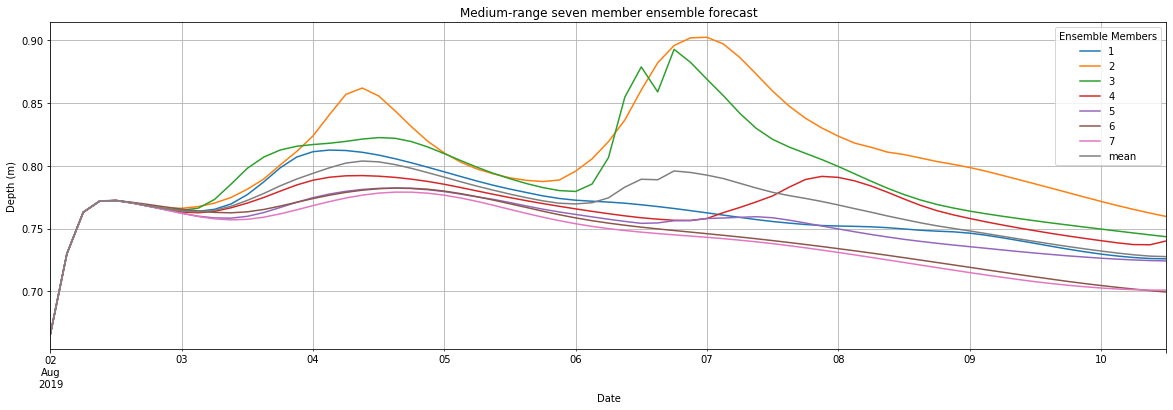

In [15]:
ax = stage_df.plot(figsize=(20,6), title='Medium-range seven member ensemble forecast')
ax.legend(title='Ensemble Members')
ax.grid(True, which="both")
ax.set(xlabel='Date', ylabel='Depth (m)');

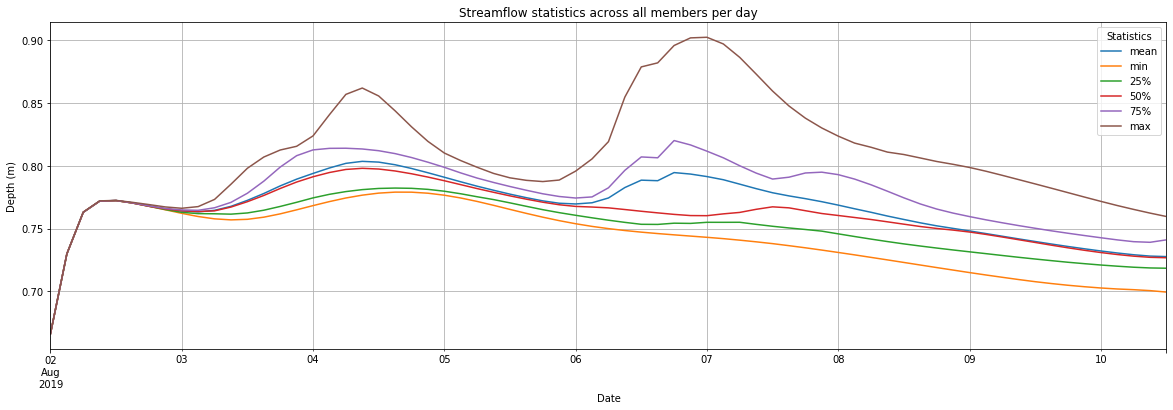

In [16]:
ax = stage_stats.T.drop(columns=['count', 'std']).plot(figsize=(20,6), title ='Streamflow statistics across all members per day')
ax.legend(title='Statistics')
ax.grid(True, which="both")
ax.set(xlabel='Date', ylabel='Depth (m)');

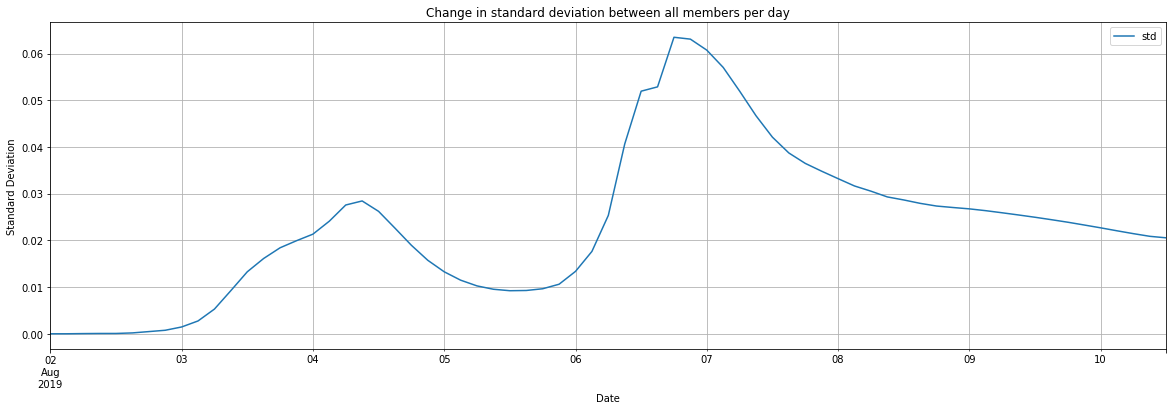

In [17]:
ax = stage_stats.T.drop(columns=[x for x in list(stats.T.columns) if 'std' not in x]).plot(figsize=(20,6), title ='Change in standard deviation between all members per day')
ax.grid(True, which="both")
ax.set(xlabel='Date', ylabel='Standard Deviation');

In [18]:
from GageUSGS import GageUSGS

In [19]:
with open('data/STATID_COMID_dict.json', 'r') as fp:
    usgs_nhd = json.load(fp)

In [20]:
gageids = []
for k, v in usgs_nhd.items():
    if v == comid:
        gageids.append(k)

In [21]:
gageids

['01646500', '01646502']

In [22]:
mathcing_gage = GageUSGS(gageids[0])

In [26]:
rc = mathcing_gage.rating_curve.dropna()
rc.head()

,INDEP,SHIFT,DEP,INDEP_SHIFT,INDEP_m,SHIFT_m,DEP_cms,INDEP_SHIFT_m
0,2.01,0.0,223.00,2.01,0.612648,0.0,6.314657,0.612648
1,2.02,0.0,226.14,2.02,0.615696,0.0,6.403572,0.615696
2,2.03,0.0,228.00,2.03,0.618744,0.0,6.456241,0.618744
3,2.04,0.0,230.80,2.04,0.621792,0.0,6.535528,0.621792
4,2.05,0.0,233.00,2.05,0.624840,0.0,6.597825,0.624840


In [27]:
f_usgs = interp1d(rc.DEP_cms, rc.INDEP_SHIFT_m, kind='cubic')
stage_df_usgs = df.apply(f_usgs)

In [28]:
stage_df_usgs.head()

,1,2,3,4,5,6,7,mean
2019-08-02 00:00:00,0.975155,0.975155,0.975155,0.975155,0.975155,0.975155,0.975155,0.975155
2019-08-02 03:00:00,1.004343,1.004343,1.004343,1.004343,1.004343,1.004343,1.004343,1.004343
2019-08-02 06:00:00,1.018714,1.018666,1.018666,1.018666,1.018666,1.018666,1.018666,1.018673
2019-08-02 09:00:00,1.022513,1.022433,1.022433,1.022433,1.022433,1.022449,1.022433,1.022447
2019-08-02 12:00:00,1.022673,1.022609,1.022609,1.022609,1.022609,1.022673,1.022609,1.022627


In [30]:
dis_df.head()

,Stage,Discharge
0,0.0000,0.000000
1,0.3048,30.085741
2,0.6096,96.720480
3,0.9144,180.899337
4,1.2192,323.340296


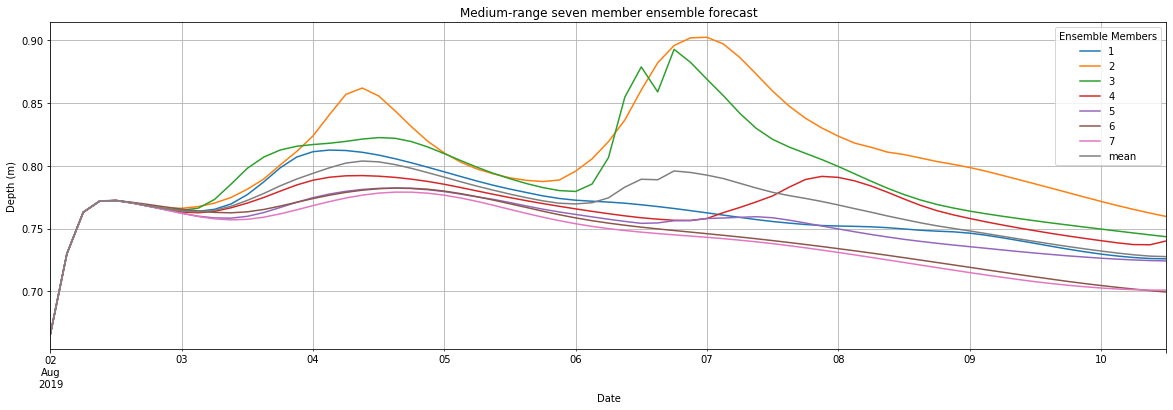

In [29]:
ax = stage_df.plot(figsize=(20,6), title='Medium-range seven member ensemble forecast')
ax.legend(title='Ensemble Members')
ax.grid(True, which="both")
ax.set(xlabel='Date', ylabel='Depth (m)');

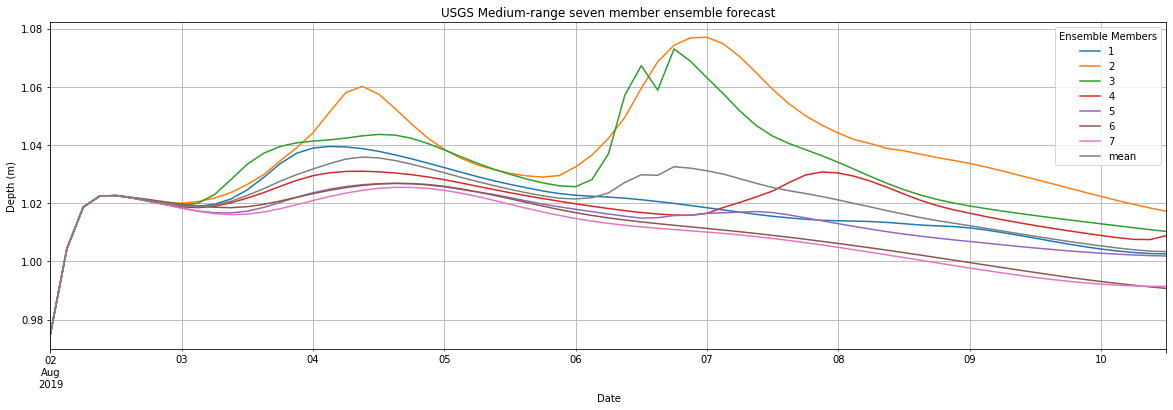

In [30]:
ax = stage_df_usgs.plot(figsize=(20,6), title='USGS Medium-range seven member ensemble forecast')
ax.legend(title='Ensemble Members')
ax.grid(True, which="both")
ax.set(xlabel='Date', ylabel='Depth (m)');

In [37]:
comparison = (stage_df - stage_df_usgs)/stage_df_usgs * 100

In [39]:
comparison.describe()

,1,2,3,4,5,6,7,mean
count,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000
mean,-25.023854,-22.208808,-23.194308,-24.869075,-25.679850,-26.203258,-26.423707,-24.772637
std,1.774345,2.800850,2.572899,1.356046,1.373313,1.825215,1.786480,1.649642
min,-31.678690,-31.678690,-31.678690,-31.678690,-31.678690,-31.678690,-31.678690,-31.678690
25%,-26.053643,-24.284879,-24.920584,-25.426168,-26.650581,-27.531106,-27.790061,-25.653712
50%,-25.001311,-22.598447,-23.572338,-24.774441,-25.398299,-25.888222,-26.155533,-24.520878
75%,-24.154819,-20.633401,-21.632395,-23.965124,-24.756819,-24.683850,-24.960939,-23.557820
max,-21.826444,-16.205694,-16.790959,-23.154760,-23.810732,-23.810732,-24.024976,-22.395745
